In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import mwclient #for getting wikipedia data
from bs4 import BeautifulSoup #for extracting desired information from html data
from bs4 import Comment #for looking through comments

import string #for string processing
import locale #for turning string to number
import re #for string processing

import json
import networkx as nx
import copy

# Airport contagion

Things we are trying to accomplish in this notebook are:
- Run a simulation of COVID-19 spreading with set locations (airports) as the only places on earth
- Get the same number of cases across the US out of the simulations as observed with real data
- Find and use an adequate metric with which to determine if the simulation is close enough


The goal is to use the empirical infectiousness of COVID-19 and simulate the spread of the virus over time, based on 24 timesteps (1 for every hour) in a day, where at every step, we have a chance equal to the infectiousness that another person gets the disease.

To determine the impact of air travel on disease spread, we measure the following:
- Only United States impact
- Dealing with continued income of infected people from outside U.S., either  
  - start with when the US closed its international airtravel (January 31st)
  - OR start from the beginning (with the first 4 cases, and randomly adding some to account for income)
- Measure only the states

## Getting US cities with primary airports

Using the MediaWiki API with the mwclient library, we can get the parsed data of a wikipedia page. With that, we gain access to information in the tables of the wiki page. If we didn't do this, we would just see the code that should populate the table, not the table after it is parsed.

In [2]:
site = mwclient.Site("en.wikipedia.org")
result = site.api('parse', prop='text', pageid=4718801) #using pageid here, because I couldn't get the call to work with the title
airports = result['parse']["text"]["*"]

Since the data is in html form, we can use BeautifulSoup to extract desired information.

In [3]:
soup = BeautifulSoup(airports, 'html.parser')

After looking at the data a bit, I noticed that the information we're after is in the third table of the page, so we first get the third table tag, and then we go through each row, keeping only the city name.

In order convert the cities to population count, we need to keep the cities ordered by their state. This also helps dealing with duplicate names like Portland, which is a city in both Oregon and Maine.

In [4]:
#get the table that has contains all of the primary airport names
airport_table = soup.findAll("table")[2]

# find all rows, which are indicated by the 'tr' tag, then get the first element (which is the city), indicated by the 'td' tag
#   furthermore, we need to check if 'td' tag exists and if it does, if it has a 'cite' tag, 
#   which indicates that the current row is actually just indicating a new state (in which case we make a new key in the dict),
#   otherwise we can add a state
airport_cities_by_state = {}
current_state = ""
for row in airport_table.findAll("tr"):
    if(row.find('td')):
        if row.find('td').find("cite"):
            current_state = row.find('td').text
            if current_state == "AMERICAN SAMOA": #this indicates that we are now covering US territories
                break
            else:
                airport_cities_by_state[current_state] = []
        else:
            new_city = row.find('td').text[:-1] #leave out the last character since it's a newline character
            
            #check for edge cases
            if new_city.find(', ') >= 0:
                #handles hawaii city names that include island name
                new_city = new_city[:new_city.find(', ')]
                
            if new_city.find('/') >= 0:
                #this case is tricky, so simply don't worry about it, the '/' indicates multiple city names, so choosing the right one is tough
                new_city = new_city[:new_city.find('/')]
                
            airport_cities_by_state[current_state].append(new_city) 
    

In [5]:
airport_cities_by_state

{'ALABAMA': ['Birmingham', 'Dothan', 'Huntsville', 'Mobile', 'Montgomery'],
 'ALASKA': ['Anchorage',
  'Anchorage',
  'Anchorage',
  'Aniak',
  'Barrow',
  'Bethel',
  'Cordova',
  'Deadhorse',
  'Dillingham',
  'Fairbanks',
  'Galena',
  'Homer',
  'Juneau',
  'Kenai',
  'Ketchikan',
  'King Salmon',
  'Kodiak',
  'Kotzebue',
  'Nome',
  'Petersburg',
  'Sitka',
  "St. Mary's",
  'Unalakleet',
  'Unalaska',
  'Valdez',
  'Wrangell',
  'Yakutat'],
 'ARIZONA': ['Bullhead City',
  'Flagstaff',
  'Grand Canyon',
  'Mesa',
  'Page',
  'Peach Springs',
  'Phoenix',
  'Tucson',
  'Yuma'],
 'ARKANSAS': ['Fayetteville', 'Fort Smith', 'Little Rock', 'Texarkana'],
 'CALIFORNIA': ['Arcata',
  'Bakersfield',
  'Burbank',
  'Fresno',
  'Long Beach',
  'Los Angeles',
  'Mammoth Lakes',
  'Monterey',
  'Oakland',
  'Ontario',
  'Orange County',
  'Palm Springs',
  'Redding',
  'Sacramento',
  'San Diego',
  'San Francisco',
  'San Jose',
  'San Luis Obispo',
  'Santa Barbara',
  'Santa Maria',
  'San

And there it is! But looking at the list of airport cities, we see some duplicates, like Anchorage. This simply means there is more than one primary airport in that city. For the purpose of this project, we don't care. So we may need to remove duplicate values, but for now let's move on to getting city populations!

## Getting city population with MediaWiki API

#### Background:
After spending some time looking for the ideal database containing all US cities with their estimated population, I came out empty handed. Since the ideal didn't exist, we now are stuck with the next best thing, which is to go to the state specific list-of-cities Wikipedia article and query that.

There is a Wikipedia article that links to all of these, based on the state, so it seems that using their links is the way to go. [This](https://en.wikipedia.org/wiki/Lists_of_populated_places_in_the_United_States) is the article I'm referring to.

In [6]:
#used to convert strings like "1,000" to integer 1000
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

In [7]:
def process_state(state_name):
    #capitalize the string and replace whitespaces with underscores
    return string.capwords(state_name.replace(" ", "_"), sep = "_")

def is_city_list(contender_str):
    lc = contender_str.lower()
    if lc.find("cities") >=0 or lc.find("municipalities") >= 0 or lc.find("_incorporated") >= 0:
        return True
    return False

def get_name_and_population_indices(column_names):
    #this will take the first mention of population in the expected table headers as the index for population
    #  more recent population information tend to come first
    name_index = -1
    name_found = False
    pop_index = -1
    pop_found = False
    for i, col_name in enumerate(column_names):
        if not name_found and ("name" in col_name or "city" in col_name or "municipality" in col_name):
            name_index = i
            name_found = True
        if not pop_found and ("pop." in col_name or "population" in col_name or "estimate" in col_name or "2020 census" in col_name):
            pop_index = i
            pop_found = True
        if pop_found and name_found:
            return name_index, pop_index
    return name_index, pop_index
    
def get_indices(soups):
    #given list of soup, extract the index of the correct table
    #  utilizes get_name_and_population_indices
    pni = -1; ppi = -1
    for i, soup in enumerate(soups):
        columns = [col.text.lower() for col in soup.findAll("th")]
        pni, ppi = get_name_and_population_indices(columns)
        if pni >= 0 and pni <= 3 and ppi >= 0:
            return i, pni, ppi
    return 0, pni, ppi #randomly choose the first table
    
def get_city_population_tuple(name, pop):
    try:
        return (name, locale.atoi(pop))
    except ValueError:
        #issue is square brackets at the end of the string
        cutoff = pop.find("[")
        return (name, locale.atoi(pop[:cutoff]))
    
def get_soup(page_name):
    result = site.api('parse', prop='text', page=page_name)
    wiki_html = result['parse']['text']['*']
    soup = BeautifulSoup(wiki_html)
    redirect = soup.findAll("div", {"class": "redirectMsg"})
    if redirect:
#         print("Redirecting")
        return get_soup(redirect[0].find('a').text)
    return soup

def text_processing(text):
    # Strip leading and tailing whitespaces, remove newline and extraneou characters
    text = re.sub(r"\n|†|‡|\*|\[*.]", "", text)
    text = text.strip()
    return text

def handle_new_city(populations, candidate_tuple):
    #check if new city is already in the list, if it is, keep the one with higher population, otherwise just append new city
    no_duplicate_tuple = True
    for i, (name, pop) in enumerate(populations):
        if candidate_tuple[0] == name:
            no_duplicate_tuple = False
            if pop > candidate_tuple[1]:
                #do not add repeating cities, keep only the largest population
                break
            else:
                populations[i] = candidate_tuple
    if no_duplicate_tuple:
        populations.append(candidate_tuple)
    return populations


def get_city_populations(cities, page_name):
    cur_soup = get_soup(page_name)
    table_tags = cur_soup.findAll("table")
    if not table_tags:
        table_tags = cur_soup.findAll("table", {"class": "wikitable sortable"})
        if not table_tags:
#             print("No table_tags")
            return None
        
    tindex, nindex, pindex = get_indices(table_tags)
    table = table_tags[tindex]

    if nindex == -1 and pindex == -1:
#         print("Could not find either name column nor population column")
        return None
    if nindex == -1:
#         print("Could not find name column")
        return None
    if pindex == -1:
#         print("Could not find population column")
        return None
    
    populations = []
    for row in table.findAll("tr")[1:]: #start from the third entry because the first is set-up
        subtractor = 0
        if row.find("th"):
            #this means we need to subtract 1 from the indices, as they assumed all columns to be use the 'td'
            subtractor = 1
        
        possible_city_tags = row.findAll("td") #not a precise way to find the city names, but it doesn't need to be, since we are checking base on our list of cities
        
        #Check if findAll returns a list or none
        if possible_city_tags:
            city_tag = possible_city_tags[nindex-subtractor]
            city = text_processing(city_tag.text)
            if city in cities:
                #using a try/except statement in order not to have to find("[") in all strings
                populations = handle_new_city(populations, get_city_population_tuple(city, row.findAll("td")[pindex-subtractor].text))
            else:
                try:
                    #if city name is not found in a 'td' tag, we can look at alternative tags
                    alt_city_tag = row.find("th") #as in the case of california, the city names are under 'th' tags
                    alt_city = text_processing(alt_city_tag.text)
                    if alt_city in cities:
                        # from the currrently encountered problem cases, it is only the first column (if any)
                        #   that is represented with a 'th' tag, rather than a 'td' tag, so just reduce pop index by 1 
                        populations = handle_new_city(populations, get_city_population_tuple(alt_city, row.findAll("td")[pindex-subtractor].text))
                except:
                    continue
    return populations

def get_city_pop_dictionary(cities_dict):
    link_soup = get_soup("Lists_of_populated_places_in_the_United_States")
    my_dict = {}
    for state in cities_dict.keys():
        for sibling in link_soup.find(id = process_state(state)).parent.find_next_siblings(limit=4)[1:]:
            for contender_tag in sibling.findAll("li"):
                if is_city_list(str(contender_tag)) or len(sibling.findAll('li')) == 1:
                    my_dict[state] = get_city_populations(cities=cities_dict[state], page_name=contender_tag.find("a").attrs['title'])
    return my_dict

city_pop_by_state = get_city_pop_dictionary(airport_cities_by_state)

Here's the first 5 states with their cities with airports and population:

In [8]:
for key in list(city_pop_by_state.keys())[:5]:
    print("{}: {}".format(key, city_pop_by_state[key]))

ALABAMA: [('Birmingham', 212237), ('Dothan', 65496), ('Huntsville', 180105), ('Mobile', 195111), ('Montgomery', 205764)]
ALASKA: [('Anchorage', 291826), ('Aniak', 501), ('Bethel', 6080), ('Cordova', 2239), ('Dillingham', 2329), ('Fairbanks', 31535), ('Galena', 470), ('Homer', 5003), ('Juneau', 31275), ('Kenai', 7100), ('Ketchikan', 8050), ('Kodiak', 6130), ('Kotzebue', 3201), ('Nome', 3598), ('Sitka', 8881), ("St. Mary's", 507), ('Unalakleet', 688), ('Unalaska', 4376), ('Valdez', 3976), ('Wrangell', 2369)]
ARIZONA: [('Bullhead City', 39540), ('Flagstaff', 65870), ('Mesa', 439041), ('Page', 7247), ('Phoenix', 1445632), ('Tucson', 520116), ('Yuma', 93064)]
ARKANSAS: [('Little Rock', 193524), ('Fort Smith', 88209), ('Fayetteville', 76899), ('Texarkana', 29919)]
CALIFORNIA: [('Arcata', 17231), ('Bakersfield', 347483), ('Burbank', 103340), ('Fresno', 494665), ('Long Beach', 462257), ('Los Angeles', 3792621), ('Mammoth Lakes', 8234), ('Monterey', 27810), ('Oakland', 390724), ('Ontario', 1639

Unfortunately gathering the data for Oregon was not possible at this time, due to the distributed layout of population information for the state (and only that state). So let's remove it.

In [119]:
del city_pop_by_state["OREGON"]
try:
    city_pop_by_state["OREGON"]
except KeyError as e:
    print("KeyError:", e)

KeyError: 'OREGON'

As we can see it throws an error when referencing Oregon, so it is no longer in the dictionary.

Now that we have done this, let's move on to the simulation.

## The Simulation
To run the simulation, we need to do the following:

1) Get a random graph for all of the cities, with the number of nodes being proportional to the population size

2) Get a simulation running on just one of these random graphs

3) Write a flight feature -- Select a random node in all the random graphs, and connect them all for one timestep

4) Find starting points of infection based on John's Hopkins University's publicly available data

5) Run the simulation

6) Evaluation

### 1. Setting up the basic graph

The basic graph of the simulation is a cumulation of many individual random graphs. But since it takes some time to create random graphs for all of the cities, let's just create them once and save them. That way we can simply load in the basic graph at the beginning of the simulation.

#### 1.1 Making the random graphs

The first step is straightforward; making the graphs. Here we use the configuration model in order to resemble community structure, where each node represents 1,000 people.

The code below may take a while.

In [10]:
city_graphs_by_state = {}
for state in city_pop_by_state:
    print("Now doing:", state)
    city_graphs_by_state[state] = []
    for city in city_pop_by_state[state]:
        n = int(city[1]/1000)
        if n <= 1:
            continue
        for i in range(9):
            try:
                sequence = nx.random_powerlaw_tree_sequence(n, tries=10**i)
                break
            except:
                continue
        G = nx.configuration_model(sequence)
        city_graphs_by_state[state].append((city[0], G))

Now doing: ALABAMA
Now doing: ALASKA
Now doing: ARIZONA
Now doing: ARKANSAS
Now doing: CALIFORNIA
Now doing: COLORADO
Now doing: CONNECTICUT
Now doing: DELAWARE
Now doing: FLORIDA
Now doing: GEORGIA
Now doing: HAWAII
Now doing: IDAHO
Now doing: ILLINOIS
Now doing: INDIANA
Now doing: IOWA
Now doing: KANSAS
Now doing: KENTUCKY
Now doing: LOUISIANA
Now doing: MAINE
Now doing: MARYLAND
Now doing: MASSACHUSETTS
Now doing: MICHIGAN
Now doing: MINNESOTA
Now doing: MISSISSIPPI
Now doing: MISSOURI
Now doing: MONTANA
Now doing: NEBRASKA
Now doing: NEVADA
Now doing: NEW HAMPSHIRE
Now doing: NEW JERSEY
Now doing: NEW MEXICO
Now doing: NEW YORK
Now doing: NORTH CAROLINA
Now doing: NORTH DAKOTA
Now doing: OHIO
Now doing: OKLAHOMA
Now doing: PENNSYLVANIA
Now doing: RHODE ISLAND
Now doing: SOUTH CAROLINA
Now doing: SOUTH DAKOTA
Now doing: TENNESSEE
Now doing: TEXAS
Now doing: UTAH
Now doing: VERMONT
Now doing: VIRGINIA
Now doing: WASHINGTON
Now doing: WEST VIRGINIA
Now doing: WISCONSIN
Now doing: WYOM

For each one thousand people in a city, we add one node. Because of this, there is a chance that some states won't have any cities represented as a graph. Let's see if this is true.

In [11]:
for state in city_graphs_by_state:
    if len(city_graphs_by_state[state]) <= 1:
        print(city_graphs_by_state[state])

[('Wilmington', <networkx.classes.multigraph.MultiGraph object at 0x000001E292DC7828>)]
[('Burlington', <networkx.classes.multigraph.MultiGraph object at 0x000001E293BF5320>)]


There are only two states for which we only have 1 city represented, however there are no states for which we have 0 cities represented. So this seems to work well.

#### 1.2 Cumulating all random graphs

In order to start the simulation with one basic graph, we need to first accumulate all of the random graphs. 

What we need to watch out for in this process, is keeping track of which nodes correspond to which city, corresponds to which state. To keep track of this, we need to create another dictionary, just like the ones before, but instead of storing the population or the random graph as the second element of the city-tuple, we will store an ID-range-tuple (min, max) that gives the lowest (inclusive) and the highest node ID (exclusive) that correspond to the particular city.

In [12]:
city_nodes_by_state = copy.deepcopy(city_graphs_by_state)

The code below may take a while.

In [13]:
cumul_graph = nx.MultiGraph() #base graph, needds to be a multigraph for now, once all is accumulated will change to normal graph
node_counter = 0
for state in city_graphs_by_state:
    print("Now doing:", state)
    for i, city in enumerate(city_graphs_by_state[state]):
        num_cur_city_nodes = city[1].number_of_nodes() #city[1] gives graph for that city
        city_nodes_by_state[state][i] = (city[0], node_counter, node_counter+num_cur_city_nodes)
        cumul_graph = nx.disjoint_union(cumul_graph, city[1])
        node_counter += num_cur_city_nodes

Now doing: ALABAMA
Now doing: ALASKA
Now doing: ARIZONA
Now doing: ARKANSAS
Now doing: CALIFORNIA
Now doing: COLORADO
Now doing: CONNECTICUT
Now doing: DELAWARE
Now doing: FLORIDA
Now doing: GEORGIA
Now doing: HAWAII
Now doing: IDAHO
Now doing: ILLINOIS
Now doing: INDIANA
Now doing: IOWA
Now doing: KANSAS
Now doing: KENTUCKY
Now doing: LOUISIANA
Now doing: MAINE
Now doing: MARYLAND
Now doing: MASSACHUSETTS
Now doing: MICHIGAN
Now doing: MINNESOTA
Now doing: MISSISSIPPI
Now doing: MISSOURI
Now doing: MONTANA
Now doing: NEBRASKA
Now doing: NEVADA
Now doing: NEW HAMPSHIRE
Now doing: NEW JERSEY
Now doing: NEW MEXICO
Now doing: NEW YORK
Now doing: NORTH CAROLINA
Now doing: NORTH DAKOTA
Now doing: OHIO
Now doing: OKLAHOMA
Now doing: PENNSYLVANIA
Now doing: RHODE ISLAND
Now doing: SOUTH CAROLINA
Now doing: SOUTH DAKOTA
Now doing: TENNESSEE
Now doing: TEXAS
Now doing: UTAH
Now doing: VERMONT
Now doing: VIRGINIA
Now doing: WASHINGTON
Now doing: WEST VIRGINIA
Now doing: WISCONSIN
Now doing: WYOM

In [14]:
cumul_graph.number_of_nodes()

70707

In [15]:
city_nodes_by_state

{'ALABAMA': [('Birmingham', 0, 212),
  ('Dothan', 212, 277),
  ('Huntsville', 277, 457),
  ('Mobile', 457, 652),
  ('Montgomery', 652, 857)],
 'ALASKA': [('Anchorage', 857, 1148),
  ('Bethel', 1148, 1154),
  ('Cordova', 1154, 1156),
  ('Dillingham', 1156, 1158),
  ('Fairbanks', 1158, 1189),
  ('Homer', 1189, 1194),
  ('Juneau', 1194, 1225),
  ('Kenai', 1225, 1232),
  ('Ketchikan', 1232, 1240),
  ('Kodiak', 1240, 1246),
  ('Kotzebue', 1246, 1249),
  ('Nome', 1249, 1252),
  ('Sitka', 1252, 1260),
  ('Unalaska', 1260, 1264),
  ('Valdez', 1264, 1267),
  ('Wrangell', 1267, 1269)],
 'ARIZONA': [('Bullhead City', 1269, 1308),
  ('Flagstaff', 1308, 1373),
  ('Mesa', 1373, 1812),
  ('Page', 1812, 1819),
  ('Phoenix', 1819, 3264),
  ('Tucson', 3264, 3784),
  ('Yuma', 3784, 3877)],
 'ARKANSAS': [('Little Rock', 3877, 4070),
  ('Fort Smith', 4070, 4158),
  ('Fayetteville', 4158, 4234),
  ('Texarkana', 4234, 4263)],
 'CALIFORNIA': [('Arcata', 4263, 4280),
  ('Bakersfield', 4280, 4627),
  ('Burbank'

You may notice that these are all multi graphs. Since we do not need them or the cumulative graph to be multigraphs, let's turn the cumulative graph into a simple graph. We can do this, because none of the edges use the multi-graph features, meaning we are only freeing up space when doing this.

In [16]:
simp_graph = nx.Graph(cumul_graph)

In [17]:
simp_graph.number_of_nodes()

70707

Now that we've accumulated all of the graphs, let's save the cumulated graph. Let's also save the city_nodes_by_state dictionary, as re-running all of the code would take a while. It may also be a good idea to free up the space that the city_graphs_by_state dictionary along with all of the graph objects are taking up. 

In [18]:
#save graph
nx.write_gml(simp_graph, "base_graph.gml")
nx.write_gml(cumul_graph, "base_multi_graph.gml")

In [63]:
json_dict = json.dumps(city_nodes_by_state)
with open("city_nodes_by_state.json", 'w') as f:
    f.write(json_dict)

In [362]:
#free space up
del city_graphs_by_state

With that we are done with part 1!

### 2. Writing the basic simulation

The basic simulation should have the following parts:

1) Read in base graph and give each node a label of either S, I, or R (Susceptible, Infected, or Recovered)

2) Start out with certain number of infected people

3) Perform timesteps, in each there's a probability (depending on $R_0$) for transmission, and to recover, nodes have to stay infected for a given number of days

In [14]:
def basic_simulation(graph, num_base_infected = 3, ro = 2.0, recover_time = 10, timesteps = 100):
    # ***** SETUP ***** #
    #set up beginning states -> all nodes have state 'S'
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    node_list = list(graph.nodes)
    vals = ['S']*num_nodes
    states = dict(zip(graph.nodes, vals))
    infected = {}
    
    mean_degree = 2*num_edges/num_nodes
    p = mean_degree/ro
    if p > 1:
        p = 1.0
    
    #next, randomly chose <num_base_infected> number of nodes, and change their state to 'I'
    origin_infected = np.random.choice(node_list, num_base_infected, replace=False)
    for node in origin_infected:
        states[node] = 'I'
        infected[node] = recover_time #number of steps until an infected node is recovered
        
    num_infected_over_time = [num_base_infected]
    
    nx.set_node_attributes
    
    # ***** SIMULATE ***** #
    for day in range(timesteps):
        #go through each infected node, check if their recovery time is 0, if yes, remove them from the dict and add them to the recovered list
        newly_recovered = []
        newly_infected = []
        for inf_node in infected:
            infected[inf_node] -= 1
            if infected[inf_node] == 0:
                #Node is recovered!
                states[inf_node] = 'R'
                newly_recovered.append(inf_node)
                continue
            for neighbor in graph.neighbors(inf_node):
#                 print(states[neighbor])
                if states[neighbor] == 'S':
                    if np.random.rand() < p:
                        states[neighbor] = 'I'
                        newly_infected.append(neighbor)
            
        for rec_node in newly_recovered:
            del infected[rec_node]
            
        for inf_node in newly_infected:
            infected[inf_node] = recover_time
            
        num_infected_over_time.append(len(infected))
    return num_infected_over_time, num_nodes

Since we haven't yet set up connections between the cities on the main graph, let's make the basic simulation run on just one city. Using Birmingham as an example.

In [29]:
n = int(212237/1000) #population from Birmingham, divided by 1000
sequence = nx.random_powerlaw_tree_sequence(n, tries=500000)
test_graph = nx.configuration_model(sequence)

In [32]:
infs, pop = basic_simulation(test_graph, num_base_infected = 10, timesteps = 30)

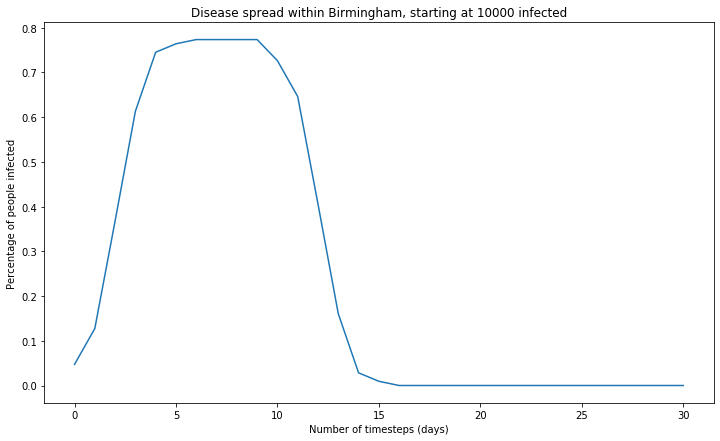

In [38]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot([inf/pop for inf in infs])
ax.set_title("Disease spread within Birmingham, starting at 10000 infected")
ax.set_xlabel("Number of timesteps (days)")
ax.set_ylabel("Percentage of people infected")
plt.show()

### 3. Adding flights to the Simulation

Since we would like to examine the impact of airtravel on the spread of the virus, we need a way to simulate flights. The way that we will do that in this case is as follows. At each timestep:

1) Choose a random node within each city

2) Randomly choose a certain number of other cities to connect the chosen node to (for all chosen nodes)

3) Remove all created edges

The tricky part here is correctly referencing nodes based on their city.

In [52]:
base_graph = nx.read_gml("base_graph.gml")
with open('city_nodes_by_state.json', 'r') as f:
    city_nodes_by_state = json.load(f)

In [61]:
def get_new_edges(proportion_fly):
    nodes_to_connect = []
    
    for state in city_nodes_by_state:
        for city in city_nodes_by_state[state]:
            #city gives name, min, max
#             print(city)
            num_city_nodes = city[2]-city[1]
            num_flights = int(num_city_nodes*proportion_fly)
            flying_nodes = [str(x) for x in np.random.choice(range(city[1],city[2]), num_flights, replace = False)]
            if len(flying_nodes) >= 1:
                nodes_to_connect.append(flying_nodes)
#     print(nodes_to_connect)
    new_edges = []
    num_connectors = len(nodes_to_connect)
    for i in range(num_connectors):
        for cur_node in nodes_to_connect[i]:
            #first choose a city to connect to, then choose a node within that city to connect to
            city_index = np.random.randint(0, num_connectors)
            if city_index == i:
                if city_index+1 == num_connectors:
                    city_index -= 1
                else:
                    city_index += 1
            city = nodes_to_connect[city_index]
            
            #now get the node within that city to connect to
            connecting_node = np.random.choice(city)
            new_edges.append((cur_node, connecting_node))
    return new_edges
    
def simulation(graph, num_base_infected = 100, ro = 2.0, recover_time = 10, proportion_fly = 0.1, timesteps = 100):
    # ***** SETUP ***** #
    #set up beginning states -> all nodes have state 'S'
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    node_list = list(graph.nodes)
    vals = ['S']*num_nodes
    states = dict(zip(graph.nodes, vals))
    infected = {}
    
    mean_degree = 2*num_edges/num_nodes
    p = mean_degree/ro
    if p > 1:
        p = 1.0
    
    #next, randomly chose <num_base_infected> number of nodes, and change their state to 'I'
    origin_infected = np.random.choice(node_list, num_base_infected, replace=False)
    for node in origin_infected:
        states[node] = 'I'
        infected[node] = recover_time #number of steps until an infected node is recovered
        
    new_infected_over_time = [num_base_infected]
    
    # ***** SIMULATE ***** #
    
    for day in range(timesteps):
        new_edges = get_new_edges(proportion_fly)
        graph.add_edges_from(new_edges)
        #go through each infected node, check if their recovery time is 0, if yes, remove them from the dict and add them to the recovered list
        newly_recovered = []
        newly_infected = []
        for inf_node in infected:
            infected[inf_node] -= 1
            if infected[inf_node] == 0:
                #Node is recovered!
                states[inf_node] = 'R'
                newly_recovered.append(inf_node)
                continue
            for neighbor in graph.neighbors(inf_node):
#                 print(states[neighbor])
                if states[neighbor] == 'S':
                    if np.random.rand() < p:
                        states[neighbor] = 'I'
                        newly_infected.append(neighbor)
            
        for rec_node in newly_recovered:
            del infected[rec_node]
            
        for inf_node in newly_infected:
            infected[inf_node] = recover_time
            
        new_infected_over_time.append(len(newly_infected))
        graph.remove_edges_from(new_edges)
    return new_infected_over_time, num_nodes

In [62]:
base_infected = 10
infs, pop = simulation(copy.deepcopy(base_graph), num_base_infected=base_infected, timesteps = 30)

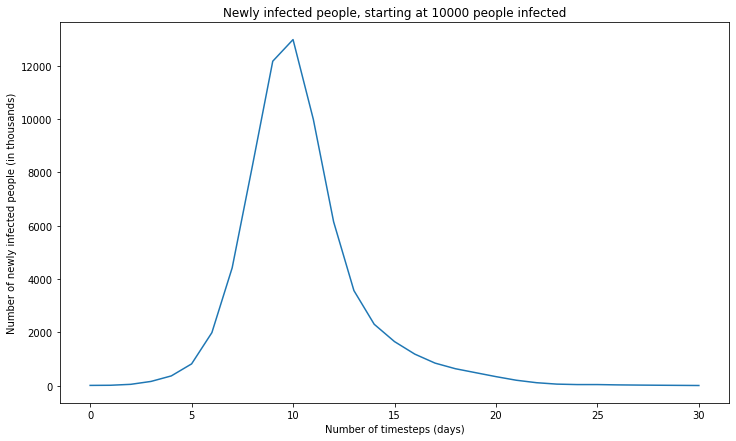

In [63]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(infs)
ax.set_title("Newly infected people, starting at " +  str(base_infected*1000) + " people infected")
ax.set_xlabel("Number of timesteps (days)")
ax.set_ylabel("Number of newly infected people (in thousands)")
plt.show()

### 4. Finding starting points of infection
To find the starting points, we need to read in the data, and then figure out which cities have around 1000 or more cases. This will allow us to place infected nodes in the correct cities, thus simulating more accurately the spread of COVID-19.

#### 4.1 Reading in the data

In [66]:
#The link below was attained by going through JHU's COVID-19 visualization github.
file_url = 'https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/JHU_USCountymap/df_Counties2020.csv'
df_us = pd.read_csv(file_url)
df_us.drop(labels = 'Unnamed: 0', axis=1, inplace = True)
df_us.head()

,Countyname,ST_Name,FIPS,ST_ID,dt,Confirmed,Deaths
0,NaN,American Samoa,60,NaN,2020-01-22,0,0.0
1,NaN,Guam,66,NaN,2020-01-22,0,0.0
2,NaN,Northern Mariana Islands,69,NaN,2020-01-22,0,0.0
3,NaN,Puerto Rico,72,NaN,2020-01-22,0,0.0
4,NaN,Virgin Islands,78,NaN,2020-01-22,0,0.0


#### 4.2 Data wrangling
Keep only the data for the states we have represented in our simulation. And for later purposes, add a day and month column.

In [67]:
#Correctly capitalizing all the state names to match the JHU data
states = [string.capwords(state) for state in city_nodes_by_state]

In [68]:
df_us = df_us[df_us["ST_Name"].isin(states)]

In [69]:
dtIndex = pd.DatetimeIndex(df_us['dt'])
df_us["day"] = dtIndex.day
df_us["month"] = dtIndex.month

#### 4.3 Finding cities to start infection
To determine where to start the virus, we will look at the number of confirmed cases on the 21st of March, the day that the US close its international borders.

In [70]:
cases = df_us.loc[(df_us["dt"] == "2020-03-21") & (df_us["Confirmed"] > 0)]

sig_cases = [num_cases for num_cases in cases["Confirmed"] if num_cases>=800]
cases[cases["Confirmed"].isin(sig_cases)]

,Countyname,ST_Name,FIPS,ST_ID,dt,Confirmed,Deaths,day,month
193789,Nassau,New York,36059,36.0,2020-03-21,1234,4.0,21,3
193790,New York,New York,36061,36.0,2020-03-21,7530,45.0,21,3
193819,Westchester,New York,36119,36.0,2020-03-21,1387,0.0,21,3
194901,King,Washington,53033,53.0,2020-03-21,934,74.0,21,3


The above shows the coounties with more than 800 confirmed cases as of March 21st.

From this we need to find out which cities are in those counties. So let's look at the cities in New York, and go through by hand. This is possible since there are only 4 total counties to look at.

In [71]:
city_nodes_by_state["NEW YORK"]

[['Albany', 37304, 37401],
 ['Binghamton', 37401, 37448],
 ['Buffalo', 37448, 37709],
 ['Elmira', 37709, 37738],
 ['Ithaca', 37738, 37768],
 ['New York', 37768, 45943],
 ['Newburgh', 45943, 45971],
 ['Niagara Falls', 45971, 46021],
 ['Plattsburgh', 46021, 46040],
 ['Rochester', 46040, 46250],
 ['Syracuse', 46250, 46395],
 ['Watertown', 46395, 46422],
 ['White Plains', 46422, 46478]]

In [72]:
city_nodes_by_state["WASHINGTON"]

[['Bellingham', 68038, 68128],
 ['Pasco', 68128, 68202],
 ['Seattle', 68202, 68946],
 ['Spokane', 68946, 69165],
 ['Walla Walla', 69165, 69197],
 ['Wenatchee', 69197, 69231],
 ['Yakima', 69231, 69324]]

In [73]:
starter_cities_by_state  = {"NEW YORK": [("New York", 9), ("White Plains", 1)], "WASHINGTON": [("Seattle", 1)]}

By going through the cities one by one, we find that New York City (New York county), White Plains (Westchester county) and Seattle (King county) will be our starter cities. Since we do not have a city in Nassau county, but New York City is very close to Nassau county, and we cannot simply overlook 1234 confirmed cases in the county, we will add an extra infected node to New York City. 

Since one node represents a thousand people in our simulation, we will start the simulation with 9 infected nodes in New York City ($7530 + 1234 \approx 9000$), and 1 infected node for both White Plains ($1387 \approx 1000$) and Seattle ($934 \approx 1000$).

### 5. Running the simulation
To run the simulation, we need to first set it up to appropriately take in the starter infections, and collect relevant information.

#### 5.1 Writing final simulation code

In [138]:
def choose_nodes_by_city(city, num_choices):
    #given a city (represented by [name, min_node, max_node]) and a number of nodes to choose,
    #  return a random <num_choices> nodes of the particular city
    return [str(x) for x in np.random.choice(range(city[1],city[2]), num_choices, replace = False)]

def get_new_edges(proportion_fly, city_nodes_by_state):
    nodes_to_connect = []
    for state in city_nodes_by_state:
        for city in city_nodes_by_state[state]:
            #city gives name, min, max
#             print(city)
            num_city_nodes = city[2]-city[1]
            num_flights = int(num_city_nodes*proportion_fly)
            flying_nodes = choose_nodes_by_city(city, num_flights)
            if len(flying_nodes) >= 1:
                nodes_to_connect.append(flying_nodes)
    
    new_edges = []
    num_connectors = len(nodes_to_connect)
    for i in range(num_connectors):
        for cur_node in nodes_to_connect[i]:
            #first choose a city to connect to, then choose a node within that city to connect to
            city_index = np.random.randint(0, num_connectors)
            if city_index == i:
                if city_index+1 == num_connectors:
                    city_index -= 1
                else:
                    city_index += 1
            city = nodes_to_connect[city_index]
            
            #now get the node within that city to connect to
            connecting_node = np.random.choice(city)
            new_edges.append((cur_node, connecting_node))
    return new_edges
    
def final_simulation(graph, city_infections_by_state, city_nodes_by_state, ro = 2.0, recover_time = 10, proportion_fly = 0.1, timesteps = 100):
    # ***** SETUP ***** #
    
    #Basic variables
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    node_list = list(graph.nodes)
    mean_degree = 2*num_edges/num_nodes
    
    #R0 gives the expected number of people infected per infected person person, so to get a probability of infection,
    #  we take the average degree and divide it by R0.
    p = ro/mean_degree
    if p > 1:
        p = 1.0
    
    #set up beginning states -> all nodes have state 'S', no nodes are infected
    vals = ['S']*num_nodes
    states = dict(zip(graph.nodes, vals))
    infected = {}
    
    #Override nodes based on starting infections
    for state in city_infections_by_state:
        for city in city_infections_by_state[state]:
            #find city in list of cities of current state
            state_city_index = 0
            for i,candidate_city in enumerate(city_nodes_by_state[state]):
                if candidate_city[0] == city[0]:
                    state_city_index = i
                    break
            
            for inf_node in choose_nodes_by_city(city_nodes_by_state[state][i], city[1]):
                states[inf_node] = 'I'
                infected[inf_node] = recover_time
        
    cases_over_time = [len(infected)]

    # ***** SIMULATE ***** #
    for day in range(timesteps):
        new_edges = get_new_edges(proportion_fly, city_nodes_by_state)
        graph.add_edges_from(new_edges)
        #go through each infected node, check if their recovery time is 0, if yes, remove them from the dict and add them to the recovered list
        newly_recovered = []
        newly_infected = []
        for inf_node in infected:
            infected[inf_node] -= 1
            if infected[inf_node] == 0:
                #Node is recovered!
                states[inf_node] = 'R'
                newly_recovered.append(inf_node)
                continue
            for neighbor in graph.neighbors(inf_node):
                if states[neighbor] == 'S':
                    if np.random.rand() < p:
                        states[neighbor] = 'I'
                        newly_infected.append(neighbor)
            
        for rec_node in newly_recovered:
            del infected[rec_node]
            
        for inf_node in newly_infected:
            infected[inf_node] = recover_time
            
        cases_over_time.append(len(infected))
        graph.remove_edges_from(new_edges)
    return cases_over_time

#### 5.2 Running final simulation

In [139]:
all_sims = []
for r_naught in [2.0, 4.0, 6.0]:
    infs = final_simulation(base_graph, starter_cities_by_state, city_nodes_by_state, timesteps=30)
    all_sims.append((r_naught, infs))

### 6. Evaluation
To evaluate our simulation, we need to compare our simulated data to the real world data. The function below should do just that.

In [190]:
def plot_spread(all_sim_data, pltDf, states = ['All'], start_date = '', end_date = '', ra_length = 7):
    #plots number of cases over time for specified states
    
    US_population = 304000000 #approximate population of the US
    if states[0] != "All":
        pltDf = pltDf[pltDf["ST_Name"].isin(states)]
    if start_date != '' and end_date != '':
        all_dates = list(df_us[df_us['dt'] >= '2020-03-21']['dt'].unique())
        all_dates = all_dates[:all_dates.index(end_date)+1]
    else:
        all_dates = pltDf['dt'].unique()
        
    all_days_real = []
    ra_real = []    
    label_indices = []
    label_names = []
    num_to_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'April 1st', 5: 'May'}
    
    all_data = []
    all_plot_labels = []
    for days_since_outbreak, date in enumerate(all_dates):
        tempDf = pltDf[pltDf['dt'] == date]
        cases_day = tempDf['Confirmed'].sum()
        all_days_real.append(cases_day)       

        #for ra_length day running average
        ra = []
        for i in range(ra_length):
            try:
                ra.append(all_days_real[days_since_outbreak-i])
            except:
                pass
        ra_real.append(np.mean(ra))
        
        #set up label indices
        if tempDf.iloc[0]['day'] == 1:
            label_indices.append(days_since_outbreak)
            label_names.append(num_to_month[tempDf.iloc[0]['month']])
    
    all_data.append(ra_real)
    all_plot_labels.append("Real Cases")
    
    for r_naught, sim_data in all_sim_data:
        ra_sims = []
        all_days_sims = []
        for days_since_outbreak, date in enumerate(all_dates):
            sims_day = sim_data[days_since_outbreak]
            all_days_sims.append(sims_day)
            ra = []
            for i in range(ra_length):
                try:
                    ra.append(all_days_sims[days_since_outbreak-i])
                except:
                    pass
            ra_sims.append(np.mean(ra))
        all_data.append(ra_sims)
        all_plot_labels.append("Simulated Cases (R0 = {:.1f})".format(r_naught))
        
    ### Plotting Stuff ###
    
    fig,ax = plt.subplots(1,1,figsize=(15,8))
    
    title = "{:d}-Day Running Average of US COVID-19 Cases (30 days timespan)".format(ra_length)#, state_string[:-2])
    
    ax.set_title(title)
    for i, ra in enumerate(all_data[1:]):
        cplot = ax.plot(ra, label = all_plot_labels[i+1])
        if i == 0:  
            cycord = cplot[0].get_ydata()[-1]
            cxcord = cplot[0].get_xdata()[-1]
            ax.annotate('{:.0f} Cases'.format(cycord),
                    xy=(cxcord, cycord),
                    xytext=(0, 10),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
#     splot = ax.plot([cases for cases in ra_sims], color = 'red', label = "Simulated Cases")
#     sycord = splot[0].get_ydata()[-1]
#     sxcord = splot[0].get_xdata()[-1]
#     ax.annotate('{:.0f} Cases'.format(sycord),
#             xy=(sxcord, sycord),
#             xytext=(0, 5),  # 5 points vertical offset
#             textcoords="offset points",
#             ha='center', va='bottom')
    
    ax.set_ylabel("Number of cases")
    ax.set_xlabel("Time (Months)")
    ax.set_xticks(label_indices)
    ax.set_xticklabels(label_names)
    ax.legend()
    
    plt.show()

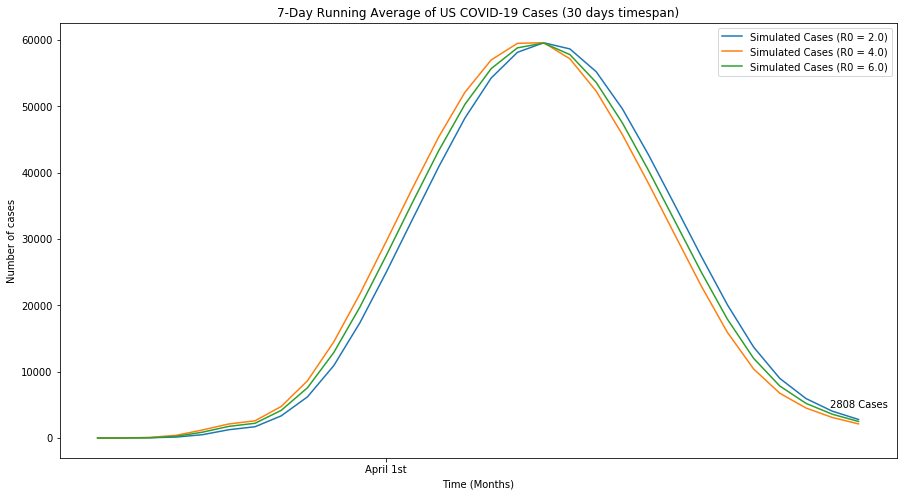

In [191]:
plot_spread(all_sims, df_us, states = states, start_date = "2020-03-21", end_date = "2020-04-19")